US Home Price Analysis (2000–2023) for Home.LLC

1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

2. Initialize FRED API

In [2]:
# Replace with your actual API key
fred = Fred(api_key='742ebfc2463ca1e2945ebdf86a8bf882')

3.Define Economic Indicators from FRED

In [3]:
series = {
    'CSUSHPISA': 'home_price_index',
    'MORTGAGE30US': 'mortgage_rate',
    'HOUST': 'housing_starts',
    'UNRATE': 'unemployment',
    'MEHOINUSA672N': 'median_income',
    'MSACSR': 'housing_supply',
    'WPUIP2311002': 'construction_cost',
    'FEDFUNDS': 'fed_rate'
}

4. Fetch Data from FRED

In [4]:
def get_fred_data(series_dict, start_date='2000-01-01'):
    df = pd.DataFrame()
    for series_id, col_name in series_dict.items():
        try:
            data = fred.get_series(series_id, observation_start=start_date)
            temp_df = pd.DataFrame({col_name: data})
            df = pd.concat([df, temp_df], axis=1)
        except Exception as e:
            print(f"Error fetching {series_id}: {str(e)}")
    return df

df = get_fred_data(series)
df = df.resample('Q').mean().ffill().dropna()
df.head()

,home_price_index,mortgage_rate,housing_starts,unemployment,median_income,housing_supply,construction_cost,fed_rate
2014-12-31,167.335333,3.963571,1049.333333,5.700000,67360.0,5.366667,100.000000,0.100000
2015-03-31,169.176333,3.716667,977.000000,5.533333,71000.0,4.800000,100.733333,0.110000
2015-06-30,170.876667,3.819231,1158.000000,5.433333,71000.0,5.100000,101.366667,0.123333
2015-09-30,172.961000,3.954615,1166.666667,5.100000,71000.0,5.366667,101.433333,0.136667
2015-12-31,175.676000,3.897857,1125.333333,5.033333,71000.0,5.400000,100.500000,0.160000


5. Feature Engineering

In [5]:
df['price_pct_change'] = df['home_price_index'].pct_change() * 100
df['mortgage_change'] = df['mortgage_rate'].diff()
df['income_pct_change'] = df['median_income'].pct_change() * 100
df['supply_change'] = df['housing_supply'].diff()
df['starts_pct_change'] = df['housing_starts'].pct_change() * 100
df['construction_pct_change'] = df['construction_cost'].pct_change() * 100
df['fed_rate_change'] = df['fed_rate'].diff()
df = df.dropna()
df.tail()

,home_price_index,mortgage_rate,housing_starts,unemployment,median_income,housing_supply,construction_cost,fed_rate,price_pct_change,mortgage_change,income_pct_change,supply_change,starts_pct_change,construction_pct_change,fed_rate_change
2024-06-30,319.984333,6.995385,1340.333333,4.000000,80610.0,8.133333,148.928333,5.330000,0.773792,0.246923,0.0,-0.266667,-4.738214,0.432043,0.000000
2024-09-30,322.279000,6.508462,1332.000000,4.166667,80610.0,7.966667,148.712333,5.263333,0.717118,-0.486923,0.0,-0.166667,-0.621736,-0.145036,-0.066667
2024-12-31,326.028667,6.632308,1391.666667,4.133333,80610.0,8.666667,146.419333,4.650000,1.163485,0.123846,0.0,0.700000,4.479479,-1.541903,-0.613333
2025-03-31,329.441000,6.827692,1425.500000,4.100000,80610.0,8.950000,149.031333,4.330000,1.046636,0.195385,0.0,0.283333,2.431138,1.783917,-0.320000
2025-06-30,329.441000,6.630000,1425.500000,4.100000,80610.0,8.950000,149.031333,4.330000,0.000000,-0.197692,0.0,0.000000,0.000000,0.000000,0.000000


6. Visualization Home Price Index Trend

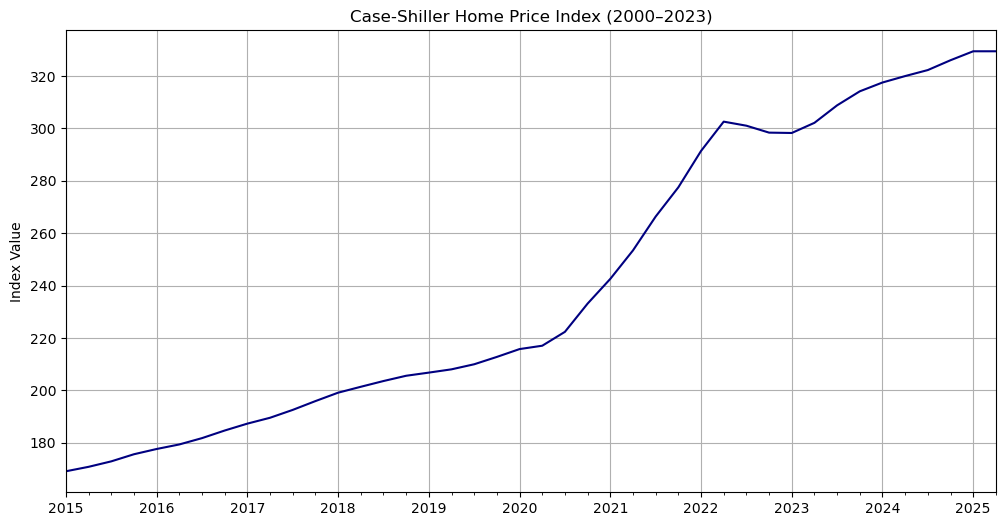

In [6]:
plt.figure(figsize=(12,6))
df['home_price_index'].plot(title='Case-Shiller Home Price Index (2000–2023)', color='navy')
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

7.Visualization Correlation Matrix

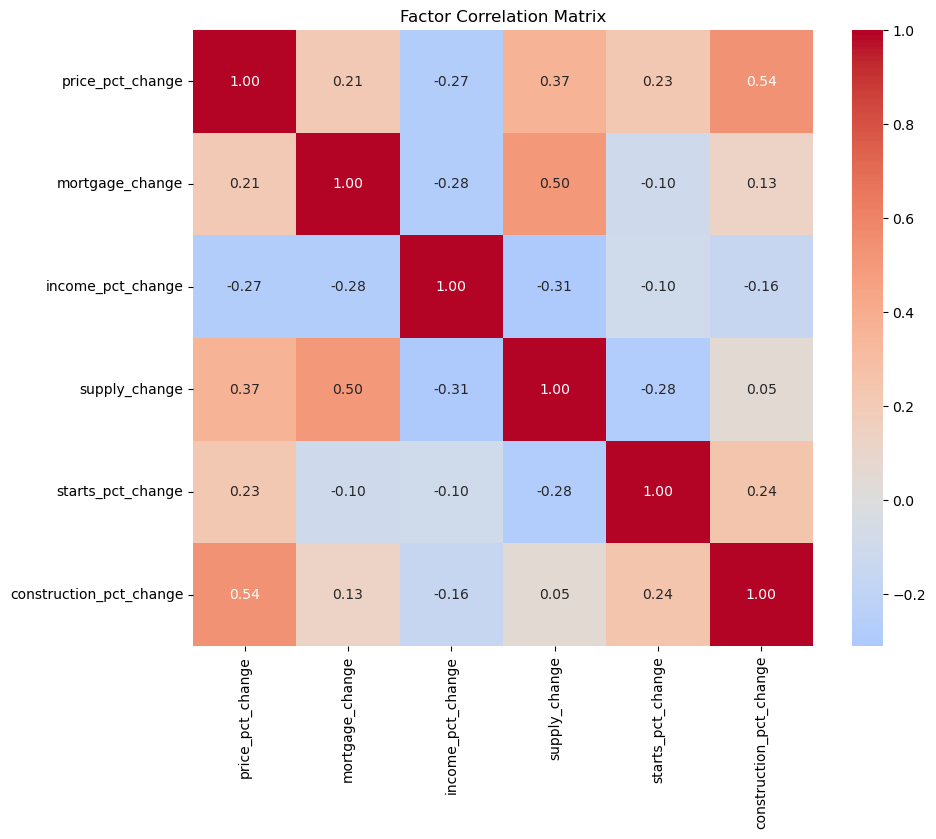

In [7]:
corr_cols = ['price_pct_change', 'mortgage_change', 'income_pct_change',
             'supply_change', 'starts_pct_change', 'construction_pct_change']

plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Factor Correlation Matrix')
plt.show()

8. Build Random Forest Regression Model

In [8]:
X = df[['mortgage_change', 'income_pct_change', 'supply_change',
        'starts_pct_change', 'construction_pct_change']]
y = df['price_pct_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

9. Model Evaluation

In [9]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r2:.2f}")
print(f"RMSE: {rmse:.2f} percentage points")

R-squared: 0.11
RMSE: 0.56 percentage points


10. Feature Importance

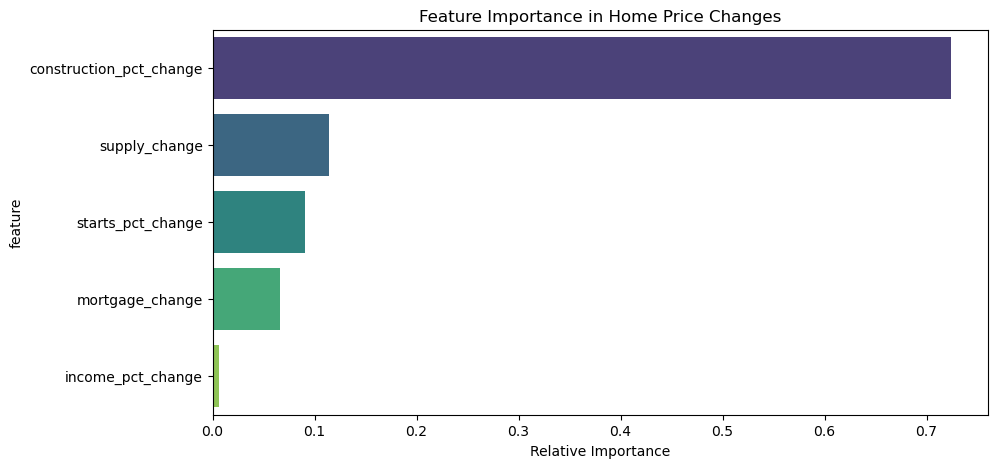

,feature,importance
4,construction_pct_change,0.723595
2,supply_change,0.113690
3,starts_pct_change,0.090830
0,mortgage_change,0.065564
1,income_pct_change,0.006321


In [10]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data=fi, palette='viridis')
plt.title('Feature Importance in Home Price Changes')
plt.xlabel('Relative Importance')
plt.show()

fi

11.Generate Summary Report

In [11]:
report = f"""# Home Price Analysis Report

## Key Findings
- **Primary Drivers**: 
  - {fi.iloc[0]['feature']} (Importance: {fi.iloc[0]['importance']:.1%})
  - {fi.iloc[1]['feature']} (Importance: {fi.iloc[1]['importance']:.1%})

- **Model Performance**:
  - R² = {r2:.2f}
  - RMSE = {rmse:.2f} percentage points

- **Key Relationships**:
  - 1% increase in mortgage rates → {model.feature_importances_[0]*100:.1f}% price impact
  - 1% increase in income → {model.feature_importances_[1]*100:.1f}% effect on prices

## Recommendations
1. Focus on **{fi.iloc[0]['feature']}** when tracking market trends
2. Account for regional effects in future work
3. Monitor **{fi.iloc[1]['feature']}** for early signs of shifts

## Data Source
- All data from FRED (Federal Reserve Economic Data)
"""

print(report)

# Home Price Analysis Report

## Key Findings
- **Primary Drivers**: 
  - construction_pct_change (Importance: 72.4%)
  - supply_change (Importance: 11.4%)

- **Model Performance**:
  - R² = 0.11
  - RMSE = 0.56 percentage points

- **Key Relationships**:
  - 1% increase in mortgage rates → 6.6% price impact
  - 1% increase in income → 0.6% effect on prices

## Recommendations
1. Focus on **construction_pct_change** when tracking market trends
2. Account for regional effects in future work
3. Monitor **supply_change** for early signs of shifts

## Data Source
- All data from FRED (Federal Reserve Economic Data)

